In [1]:
# Standard Libraries
import os
import numpy as np 
import pandas as pd 
import random as rn

# Visualization libraries
import pydotplus
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style({"axes.facecolor": ".95"})

# Modeling and Machine Learning
from IPython.display import Image 
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.externals.six import StringIO  
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz

# Seed for reproducability
seed = 1234
np.random.seed(seed)
rn.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

import sys
sys.path.append("../")
from src.scalers import *
from src.metrics import *

### Load data

In [2]:
# Load in training and testing data
train_df = pd.read_csv('../input/digit-recognizer/train.csv')
test_df = pd.read_csv('../input/digit-recognizer/test.csv')
concat_df = pd.concat([train_df, test_df])

# Get all pixel features
features = [col for col in train_df.columns if col.startswith('pixel')]
# Split up training to for validation
X_train, X_val, y_train, y_val = train_test_split(train_df[features], 
                                                  train_df['label'], 
                                                  test_size=0.1, 
                                                  random_state=seed)

## Dimensionality 
### ReductionTruncated Singular Value Decomposition (TSVD) and t-SNE (t-distributed Stochastic Neighbor Embedding)

We first compress the data using Truncated Singular Value Decomposition (TSVD).
The reason we don't perform t-SNE on the full dataset is because of computation and stability.
TSVD is ideal for if you want to compress sparse data.
If you are dealing with dense data then Principal Component Analysis (PCA) is often a better dimensionality reduction technique.

In [3]:
# Perform Truncated Singular Value Decomposition (TSVD) on all features
# This will reduce the amount of features to 50 and will simplify t-SNE

tsvd = TruncatedSVD(n_components=50).fit_transform(concat_df[features])

After compressing the 784 pixel features to 50 features we train the t-SNE algorithm.
Note that we can train the algorithm on the train and testing data combined. We don't need the target because of t-SNE's unsupervised nature.

In [4]:
# Fit t-SNE on the Truncated SVD reduced data (50 features)
tsne = TSNE(n_components=2, verbose=4)
transformed = tsne.fit_transform(tsvd) 

# Split up the t-SNE results in training and testing data
tsne_train = pd.DataFrame(transformed[:len(train_df)], columns=['component1', 'component2'])
tsne_test = pd.DataFrame(transformed[len(train_df):], columns=['component1', 'component2'])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 70000 samples in 0.341s...
[t-SNE] Computed neighbors for 70000 samples in 529.549s...
[t-SNE] Computed conditional probabilities for sample 1000 / 70000
[t-SNE] Computed conditional probabilities for sample 2000 / 70000
[t-SNE] Computed conditional probabilities for sample 3000 / 70000
[t-SNE] Computed conditional probabilities for sample 4000 / 70000
[t-SNE] Computed conditional probabilities for sample 5000 / 70000
[t-SNE] Computed conditional probabilities for sample 6000 / 70000
[t-SNE] Computed conditional probabilities for sample 7000 / 70000
[t-SNE] Computed conditional probabilities for sample 8000 / 70000
[t-SNE] Computed conditional probabilities for sample 9000 / 70000
[t-SNE] Computed conditional probabilities for sample 10000 / 70000
[t-SNE] Computed conditional probabilities for sample 11000 / 70000
[t-SNE] Computed conditional probabilities for sample 12000 / 70000
[t-SNE] Computed conditional probabilities for s

Besides compressing data and making simple algorithms more effective on high-dimensional data, t-SNE can also be used to create intuitive and beautiful visualizations of data.
As you can see in the graph below the classes are clearly distinct from each other when compressed into a 2-dimensional space.
Also, images that are similar like 3 and 9 are closer to each other than 0 and 7.
In the MNIST dataset, some 7's look pretty much like a 1 and this is reflected in the t-SNE visualization.

A downside of creating a classifiers using compressed data can be that a model like a decision tree becomes less interpretable.
We don't know which specific feature influences the result because all features are made up of a combination of features.
We can counter this by compressing groups of features that have a similar meaning and have a high correlation with each other.

C:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


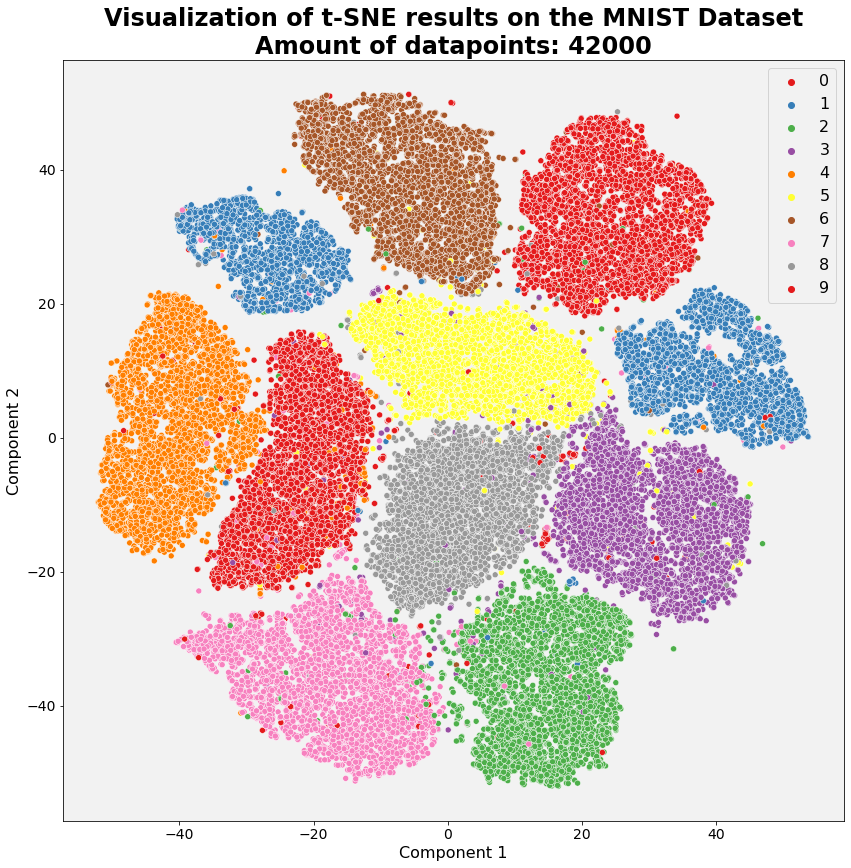

In [5]:
# Visualize the results for t-SNE on MNIST
plt.figure(figsize=(14, 14))
plt.title(f"Visualization of t-SNE results on the MNIST Dataset\n\
Amount of datapoints: {len(tsne_train)}", fontsize=24, weight='bold')
sns.scatterplot("component1", "component2", 
                data=tsne_train, hue=train_df['label'], 
                palette="Set1", legend="full")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Component 1", fontsize=16)
plt.ylabel("Component 2", fontsize=16)
plt.legend(fontsize=16);

In [6]:
# Perform another split for t-sne feature validation
X_train, X_val, y_train, y_val = train_test_split(tsne_train, 
                                                  train_df['label'], 
                                                  test_size=0.1, 
                                                  random_state=seed)

In [7]:
# Train model with t-sne features
clf = DecisionTreeClassifier(max_depth=10, random_state=seed)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
            splitter='best')

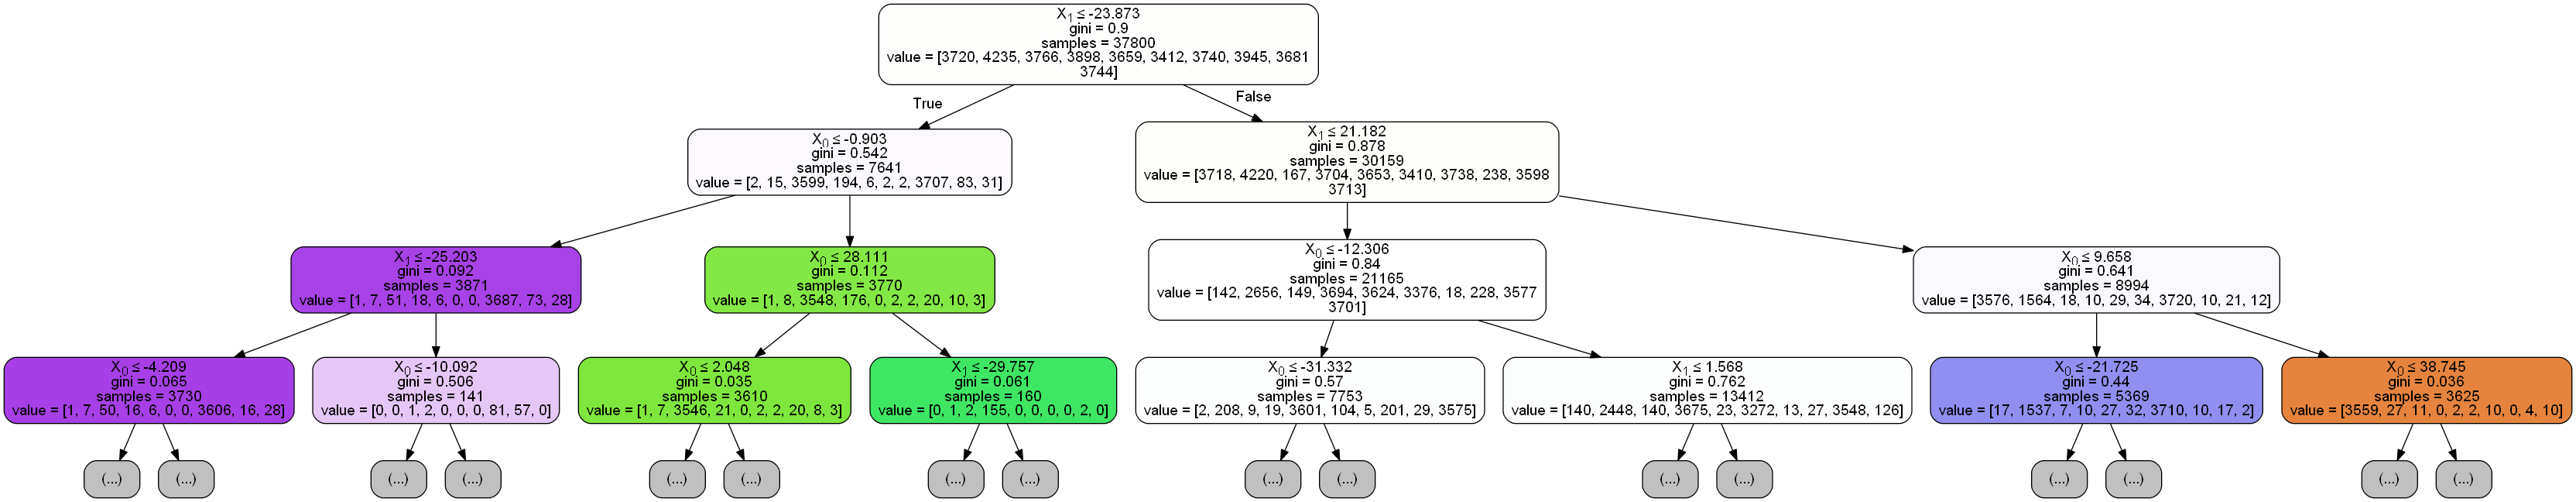

In [16]:
# Convert Decision Tree to visualization
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, 
                max_depth=3)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

# Create PNG file
Image(graph.create_png())

In [12]:
y_proba = clf.predict_proba(X_val)
y_pred = np.argmax(y_proba, axis=-1)

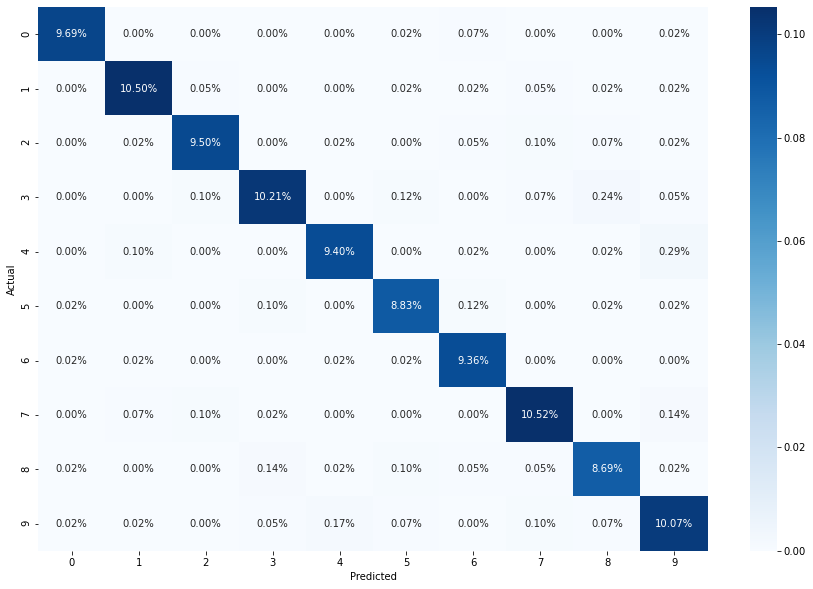

In [14]:
accuracy = plot_confusion_matrix(y_val, y_pred, fig_size=(15, 10))

In [15]:
print(f'Accuracy {accuracy}')

Accuracy 0.9678571428571429
